<span style="color: blue;">Content:</span>

1. [Load Python Packages](#1)
2. [Simplified Source Code](#2)
3. [Appendix](#3)
   * [Justification of Keeping Outliers](#4)
   * [Justification of Not Scaling the Variables](#5)
   * [Justification of Sample Size](#6)
   * [Demonstrating XGBoost is better than the Linear Model (Logistic Regression)](#7)
   * [Showing correlation between selected features are low](#8)
   * [Residual Analysis and Feature Importance Rank](#9)

### This supplementary code is designed to provide analysis in response to reviewers' questions. It  includes our previous work in a simplified form. However, we have added an appendix at the end, which contains the source codes for the analysis referenced in our responses to the reviewers.

<a id = "1"></a><br>
# Load Python Pakages


In [105]:
#pip install git+https://github.com/scikit-learn-contrib/imbalanced-learn.git@master

In [106]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


#feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel

#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,  f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer


# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 10


<a id = "2"></a><br>
#  Simplified Source Code

In [108]:
# Read the data
train_df = pd.read_excel("C:\\Users\\Rıza\\Desktop\\evrim\\midus_data_evrim.xls")


In [109]:
#An important decision: Include only Age and Sex along with blood sample measurements.
#Other sample chracteristics and redundant features are exculuded
#train_df = train_df.drop(['BMI','Education','PA level','WHR','Serum IL6 (pg/mL)','Serum Soluble IL6 Receptor (pg/mL)'], axis=1)

#correct column name
train_df.rename(columns={'HgbA1c': 'HgA1c'}, inplace=True)

#Important decision 2: Analysis include only elderly people 
train_df = train_df[train_df['Age']>= 60]
train_df.shape

(405, 36)

In [110]:
train_df = train_df.dropna(subset=['Gait speed'])

In [111]:
# Gait speed is mapped to 0 and 1. 1 indicates samples has a Gait speed below 0.8 m / s
train_df['Gait speed'] = (train_df['Gait speed'] < 0.8 ).astype(int)

In [112]:
# Store continuous and discrete features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Gait speed"]

discrete_features = [ 'Sex']

continuous_features = list(set(feature_list) - set(discrete_features))

assert feature_list.sort() == (discrete_features + continuous_features).sort()


In [113]:
#for imputing missing values
preprocessor = SimpleImputer(strategy='mean')

#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

In [114]:
# reserve a copy of data
train_df_copy = train_df.copy()

#seperate target
y = train_df['Gait speed']
train_df = train_df.drop(['Gait speed'], axis=1)


In [115]:
#create train-test split. 
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(319, 35) (80, 35)


In [116]:
#Parameters found in tuning process by Optuna
xgb_optuna_params1 = {'n_estimators': 376, 'alpha': 0.000402612165325408, 'subsample': 0.26337477699169953, 
                      'colsample_bytree': 0.6230940284871702, 'max_depth': 12, 'min_child_weight': 8,
                      'learning_rate': 0.005497165288965543, 'gamma': 0.0009854270359337684}

# Model pipeline with found hyperparameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    
    ('preprocessor', preprocessor),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])

In [117]:

# Cross-validate and report CV and test results
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='f1')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.399
Test Score: 0.462


In [118]:
%%time


# Cv method

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

# Create a pipeline for feature selection
pipeline = imbpipeline([
    ('preprocessor', preprocessor),
     ('smote', sm),
    ('selector', SelectFromModel(xgb_tunned1, threshold=-np.inf, max_features= 6)),
    ('classification',xgb_tunned1)
])

# Fit the pipeline on the training data to select features
pipeline.fit(X_train, y_train)

CPU times: total: 3.89 s
Wall time: 344 ms


Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('smote', SMOTE(random_state=10)),
                ('selector',
                 SelectFromModel(estimator=XGBClassifier(alpha=0.000402612165325408,
                                                         base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=0.6230940284871702,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005497165288965543, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=8, missing=nan,
                               monotone_constraints=None, n_estimators=376,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [119]:
#Prints out selected and eleminated features
selected_features = np.array( preprocessor.get_feature_names_out())[pipeline.named_steps['selector'].get_support()]

print("Number of selected features:", len(selected_features))

print("_______________________________")

print("Selected features:", selected_features)


print("_______________________________")

print("Dropped features:", list(set(X_train.columns) - set(selected_features)))



Number of selected features: 6
_______________________________
Selected features: ['HgA1c' 'IL-6' 'IL-8' 'CRP' 'Age' 'Sex']
_______________________________
Dropped features: ['triglycerides', 'Trans beta carotene', 'Alpha carotene', 'Zeaxanthin', 'Total cholesterol/HDL', 'Intercellular adhesion molecule 1', 'Beta-cryptoxanthin', 'IGF-1', 'Fibrinogen', 'Lutein', 'LDL', 'HDL', 'Lycopene', 'Glucose', 'Amino terminal propeptide type 1 procollagen', 'TNF alpha', 'Retinol', 'Bone specific alkaline phosphatase', 'DHEA-S', 'Gamma tocopherol', 'DHEA', 'n-Telopeptide type 1 collagen', 'Total cholesterol', 'Creatinine', 'Insulin', 'Alpha tocoperol', 'E-selectin', '13-cis-beta-carotene', 'IL-10']


In [120]:
# Reduce feature set to selected ones
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [121]:
# Report Cross-validation score with selected features
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='f1')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.427
Test Score: 0.526


In [122]:
xgb_optuna_params1 =  {'n_estimators': 422, 'alpha': 0.00025316727636985045, 'subsample': 0.2625265855043195, 
                       'colsample_bytree': 0.22066847706109496, 'max_depth': 6, 'min_child_weight': 9,
                       'learning_rate': 0.0003133276734497596, 'gamma': 1.468816194758717e-06}

# Model pipeline with found hyperparameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    ('preprocessor', preprocessor),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])

pipe_xgb1

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('smote', SMOTE(random_state=10)),
                ('xgb_tunned',
                 XGBClassifier(alpha=0.00025316727636985045, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.22066847706109496,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=No...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0003133276734497596,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=9,
                               missing=nan, monotone_constraints=None,
                               n_estimators=422, n_jobs=None,
                               num_parallel_tree=None, predictor=None, ...))])

In [123]:
# F1 Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

xgb_cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='f1')  #cross-validation
print("XGB Mean CV Score: {:.3f}".format(np.mean(xgb_cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

XGB Mean CV Score: 0.461
Test Score: 0.537


In [124]:
#pip install shap

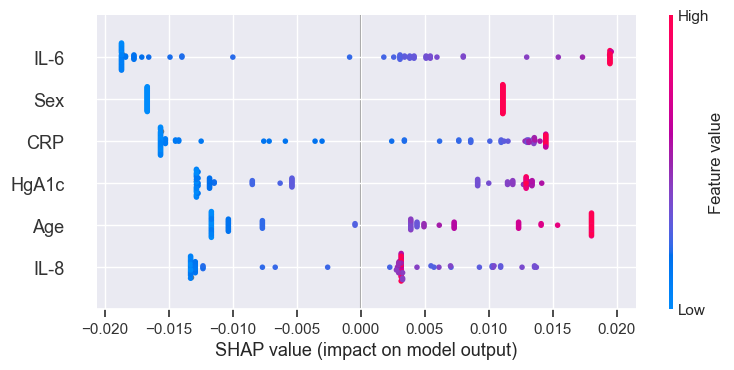

In [125]:
import shap

explainer = shap.TreeExplainer(pipe_xgb1.named_steps['xgb_tunned'], data=X_train_selected, feature_perturbation='interventional')


shap_values = explainer.shap_values(X_test_selected)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test_selected)

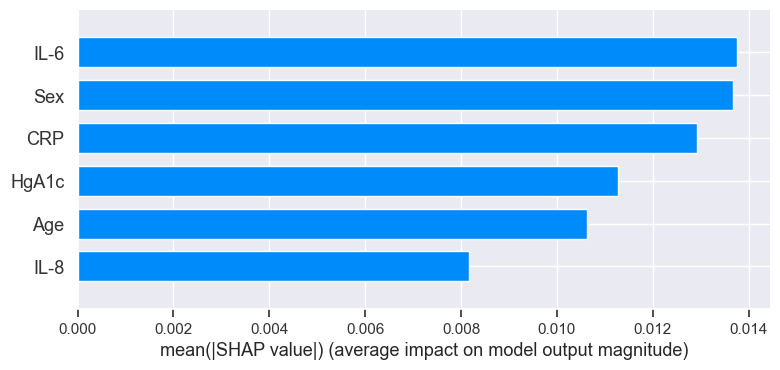

In [126]:
shap.summary_plot(shap_values, X_test_selected, plot_type = 'bar')

<a id = "3"></a><br>
#  Appendix

<a id = "4"></a><br>
# Justification of keeping outliers

#### Related questions: 
* How were outlier values of biomarkers handled in the data? Why wasn't data transformed into uniform format?

In [130]:
#take a fresh copy of data and impute missing values
df = train_df_copy.copy()
df = df [['HgA1c', 'IL-6', 'IL-8', 'CRP', 'Age', 'Sex', 'Gait speed' ]]
imputer = SimpleImputer(strategy='mean')
df[['HgA1c', 'IL-6', 'IL-8', 'CRP', 'Age', 'Sex', 'Gait speed' ]] = imputer.fit_transform(df)

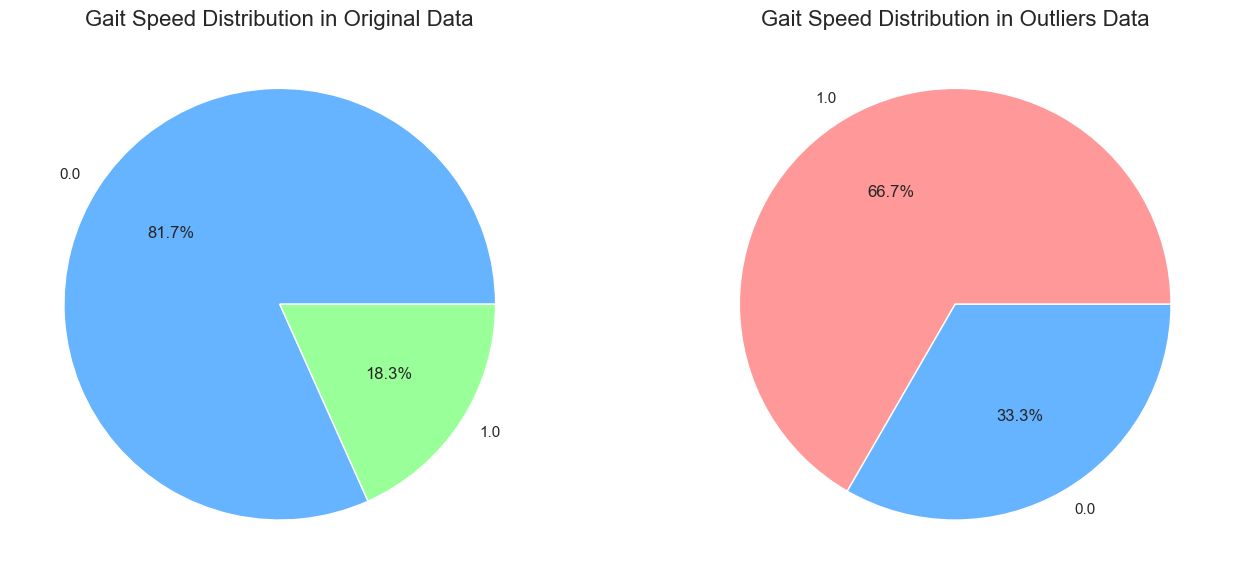

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
iso_forest = IsolationForest(random_state=random_state)
outliers = iso_forest.fit_predict(df)

# Convert outlier labels to boolean; -1 indicates outliers, 1 indicates normal points
outliers_df = df[outliers == -1]
non_outliers_df = df[outliers == 1]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1x2 grid layout

# Set style
sns.set(style="whitegrid")

# Pie chart for original df
df_gait_counts = df['Gait speed'].value_counts()
axes[0].pie(df_gait_counts, labels=df_gait_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#99ff99'])
axes[0].set_title('Gait Speed Distribution in Original Data', fontsize=16)

# Pie chart for outliers_df
outliers_df_gait_counts = outliers_df['Gait speed'].value_counts()
axes[1].pie(outliers_df_gait_counts, labels=outliers_df_gait_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
axes[1].set_title('Gait Speed Distribution in Outliers Data', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [132]:
len(outliers_df)

78

The above comparison plot shows that samples flagged as outliers contain higher rates of low gait speed samples. In classification problems, extreme values in independent variables often belong to a particular class and provide crucial information. Dropping them as outliers generally degrades the predictive model performance.

<a id = "5"></a><br>
# Justification of not scaling the varaibles

#### Related questions:
* How were outlier values of biomarkers handled in the data? Why wasn't data transformed into uniform format?
* How is the variability in the biomarker scale and its variability handled in the model? Did that lead to adjustment of the model? Is there a need of transformation of data into similar scale?


In [136]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

# Hyperparameters for XGBoost
xgb_optuna_params1 = {
    'n_estimators': 422,
    'alpha': 0.000253,
    'subsample': 0.262527,
    'colsample_bytree': 0.220668,
    'max_depth': 6,
    'min_child_weight': 9,
    'learning_rate': 0.000313,
    'gamma': 0.000001
}

# Create the XGBoost classifier with the optimized parameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

# List of scalers to test
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScaler', MaxAbsScaler()),
    ('RobustScaler', RobustScaler()),
    ('QuantileTransformer', QuantileTransformer())
]

# Results list
results = []

# Loop over each scaler
for scaler_name, scaler in scalers:
    # Create the pipeline
    pipe_xgb1 = imbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=random_state)),
        ('scaler', scaler),
        ('xgb_tunned', xgb_tunned1)
    ])
    
    # Cross-validation score
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
    cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='f1')
    mean_cv_score = np.mean(cv_scores)
    
    # Fit on the entire training set and predict on the test set
    pipe_xgb1.fit(X_train_selected, y_train)
    preds_test = pipe_xgb1.predict(X_test_selected)
    test_score = f1_score(y_test, preds_test)

    # Append results
    results.append({
        'Scaler': scaler_name,
        'Mean CV F1 Score': mean_cv_score,
        'Test F1 Score': test_score
    })

# Convert results to a pandas DataFrame for easy comparison
results_df = pd.DataFrame(results)

#Original work without any preprocessing
new_row = pd.DataFrame([{'Scaler': 'None(Original work)', 'Mean CV F1 Score': 0.461, 'Test F1 Score': 0.537}])

# Concatenate the new row to the DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the updated DataFrame
results_df.round(3)

,Scaler,Mean CV F1 Score,Test F1 Score
0,StandardScaler,0.461,0.537
1,MinMaxScaler,0.461,0.537
2,MaxAbsScaler,0.461,0.537
3,RobustScaler,0.461,0.537
4,QuantileTransformer,0.460,0.537
5,None(Original work),0.461,0.537


The above code compares the performance of XGBoost using different preprocessing techniques. The results show that XGBoost is not sensitive to scaling, as the model performs equally well without any preprocessing as it does with various preprocessing methods.

<a id = "6"></a><br>
# Justification of sample size

#### Related questions: 

* Was the sample size enough for the analysis? can the prediction being replicated in another study which has the same variables?
* It is known that machine learning technics are only robust with large samples due to the great number of neurons or predictors entered in the model. Have the authors calculated the sample size for their models?

In [140]:
#Create a fresh instance of model 
xgb_optuna_params1 =  {'n_estimators': 422, 'alpha': 0.00025316727636985045, 'subsample': 0.2625265855043195, 
                       'colsample_bytree': 0.22066847706109496, 'max_depth': 6, 'min_child_weight': 9,
                       'learning_rate': 0.0003133276734497596, 'gamma': 1.468816194758717e-06}

# Model pipeline with found hyperparameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    ('preprocessor', preprocessor),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])

pipe_xgb1

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('smote', SMOTE(random_state=10)),
                ('xgb_tunned',
                 XGBClassifier(alpha=0.00025316727636985045, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.22066847706109496,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=No...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0003133276734497596,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=9,
                               missing=nan, monotone_constraints=None,
                               n_estimators=422, n_jobs=None,
                               num_parallel_tree=None, predictor=None, ...))])

In [ ]:
#SAMPLE SIZE ANALYSIS

# Lists to store mean F1 scores and standard deviations
mean_f1_scores = []
std_f1_scores = []
data_percentages = range(30, 101, 1)

for percent in data_percentages:
    # Calculate the number of samples corresponding to the percentage
    n_samples = int(len(X_train_selected) * (percent / 100.0))
    
    # Create the subset of the data
    X_subset = X_train_selected[:n_samples]
    y_subset = y_train[:n_samples]
    
    # Perform cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
    cv_scores = cross_val_score(pipe_xgb1, X_subset, y_subset, cv=cv, scoring='f1')
    
    # Store the mean and standard deviation of F1 scores
    mean_f1_scores.append(np.mean(cv_scores))
    std_f1_scores.append(np.std(cv_scores))

# Plot the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data_percentages, mean_f1_scores, yerr=std_f1_scores, fmt='o-', capsize=5)
plt.title('Mean F1 Score vs. Percentage of Training Data Used')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Mean F1 Score')
plt.grid(True)
plt.show()


Above code measures model performance with the increasing amount of data using cross validation. It can be observed that the performance reach a plateau after around the 60-70 percent of the data is used. We can conlude that sample size is enough and adding more data will not make major differences in terms of model performance. 

reference for the method: https://www.researchgate.net/publication/335779941_Sample-Size_Determination_Methodologies_for_Machine_Learning_in_Medical_Imaging_Research_A_Systematic_Review

In addition to above analysis to get reliable and reproducible results we used a very aggressive cross validation strategy during model development (5 folds 10 repeats). We can confidently say that our results are replicable. 


<a id = "7"></a><br>
# Demonstrating XGBoost is better than the Linear Model (Logistic Regression)

#### Related questions: 

* In short, the author should stress the added benefits the manuscript provides using this machine learning strategy than using a regular model to find association of these markers with the gait phenotype. Were the same variables being associated in linear model with gait adjusting for age and gender?

* It would be nice if the author could give simplistic association of all these phenotypes with gait velocity adjusting for age, gender and other covariates. Might take gait velocity as linear model or slow gait in logistic model. A comparison can be done with the result author observed in this study.

In [ ]:
#Tunes a logistic regression model 
#def objective(trial):
    # Regularization strength (inverse of regularization coefficient)
#    C = trial.suggest_float("C", 1e-4, 10.0, log=True)

    # Maximum number of iterations
#    max_iter = trial.suggest_int("max_iter", 500, 3000)

    # Tolerance for stopping criteria
#    tol = trial.suggest_float("tol", 1e-6, 1e-2, log=True)

    # Penalty type (Regularization type)
#    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])

    # Solver (Algorithm to use in the optimization problem)
#    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "newton-cg", "lbfgs"])

    # Ensure the solver and penalty are compatible
#    if solver in ["newton-cg", "lbfgs"] and penalty not in ["l2", "none"]:
#        raise optuna.exceptions.TrialPruned()  # Prune the trial if invalid combination

#    if solver == "liblinear" and penalty not in ["l1", "l2"]:
#        raise optuna.exceptions.TrialPruned()  # Prune the trial if invalid combination

#    if solver == "saga" and penalty == "none":
#        raise optuna.exceptions.TrialPruned()  # Prune the trial if invalid combination

    # ElasticNet mixing parameter, relevant only when penalty is 'elasticnet'
#    l1_ratio = None
#    if penalty == "elasticnet":
#        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # Logistic Regression classifier
#    logreg_clf = LogisticRegression(
#        C=C,
#        tol=tol,
#        penalty=penalty if penalty != "none" else None,
#        solver=solver,
#        l1_ratio=l1_ratio,   # l1_ratio is used only for 'elasticnet' penalty
#        random_state=random_state,
#        max_iter=max_iter    # Maximum number of iterations for solver to converge
#    )
   
    # Create a pipeline
#    logreg_pipeline = imbpipeline([
#        ('preprocessor', preprocessor),
#        ('StandardScaler', StandardScaler()),
#        ('smote', SMOTE(random_state=random_state)),
#        ("logreg_clf", logreg_clf)
#    ])
    
    # Cross-validation strategy
#    ss = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#    score = cross_val_score(logreg_pipeline, X_train_selected, y_train, scoring=make_scorer(f1_score), cv=ss)
#    score = score.mean()
    
#    return score

# Create a seed for the sampler for reproducibility
#sampler = TPESampler(seed=random_state)
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=300)


In [ ]:
#Best parameters found by above optimization code
log_optuna_params =   {'C': 0.18984032472898021, 'max_iter': 2547, 'tol': 5.8886746050158735e-05, 'penalty': 'l2', 'solver': 'liblinear'}

# Linear model pipeline with found hyperparameters
logreg_clf = LogisticRegression(**log_optuna_params, random_state=random_state)


logreg_pipeline = imbpipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=random_state)),
        ('StandardScaler', StandardScaler()),
        ("logreg_clf", logreg_clf)
    ])

logreg_pipeline

In [ ]:
# F1 Cross-validation score of linear model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

log_cv_scores = cross_val_score(logreg_pipeline, X_train_selected, y_train, cv=cv, scoring='f1')  #cross-validation
print("LogReg Mean CV Score: {:.3f}".format(np.mean(log_cv_scores)))

#Test score
logreg_pipeline = logreg_pipeline.fit(X_train_selected, y_train)
preds_test = logreg_pipeline.predict(X_test_selected)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

In [ ]:
#This code seems complicated but all it does is plotting comparison graph
#Compare linear model and XGBoost

data = pd.DataFrame({
    'Model': ['XGBoost'] * len(xgb_cv_scores) + ['Logistic Regression'] * len(log_cv_scores),
    'Score': np.concatenate([xgb_cv_scores, log_cv_scores])
})

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot on the first subplot
sns.boxplot(ax=axes[0], x='Model', y='Score', data=data, palette="Set2", showfliers=False)

# Calculate means for each model
mean_xgb = np.mean(xgb_cv_scores)
mean_log = np.mean(log_cv_scores)

# Plot means on top of the box plots
axes[0].scatter(['XGBoost', 'Logistic Regression'], [mean_xgb, mean_log], 
                color='red', zorder=5, label='Mean', s=100, edgecolor='black')

# Adding mean value annotations
axes[0].text(0, mean_xgb, f'{mean_xgb:.3f}', color='red', ha='center', va='bottom', fontsize=14, fontweight='bold')
axes[0].text(1, mean_log, f'{mean_log:.3f}', color='red', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customizing the box plot
axes[0].set_title('Comparison of CV Scores: XGBoost vs Logistic Regression', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=14)
axes[0].set_ylabel('CV Score', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# KDE plot on the second subplot
sns.kdeplot(xgb_cv_scores, ax=axes[1], label='XGBoost', fill=True, color="skyblue", alpha=0.6)
sns.kdeplot(log_cv_scores, ax=axes[1], label='Logistic Regression', fill=True, color="orange", alpha=0.6)

# Plot means
axes[1].axvline(mean_xgb, color='blue', linestyle='--', label=f'XGBoost Mean: {mean_xgb:.3f}')
axes[1].axvline(mean_log, color='darkorange', linestyle='--', label=f'Logistic Regression Mean: {mean_log:.3f}')

# Customizing the KDE plot
axes[1].set_title('Distribution of CV Scores: XGBoost vs Logistic Regression', fontsize=16, fontweight='bold')
axes[1].set_xlabel('CV Score', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


As ıt can be seen from the CV comparison plots XGboost has a better mean CV score (3.8%) and has less variation on its predictive performance. 

<a id = "8"></a><br>
## Showing correlation between selected features are low 

#### Related questions: 

* How would authors explain potential collinearities among predictors? This can have potential implications and confusions in the explanation of the results.

In [ ]:
# Dşsplay correlation between features that included in the final model 

sns.set(font_scale=1.1)
correlation_train = X_train_selected.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

We observe that correlation between features are low to moderate. Which suggests that significant multicollinearity is unlikely.

<a id = "9"></a><br>
## Residual analysis and feature importance rank 

#### Related questions: 

* Since age and sex were strong predictors in the model, I would recommend to preadjust the blood markers by age and sex through residual analysis then (re-) enter them in the machine learning model to check if the order of the prediction contribution changes.

The above correlation heatmap shows low correlations between age & sex, and other features. We can expect that after readjustment, there will not be a significant change in the feature's contribution order. 

But for a sanity check, we can apply the suggested method. 

In [ ]:
#Adjusting the blood markers by age and sex through residual analysis

import statsmodels.api as sm


blood_markers = ['HgA1c', 'IL-6', 'IL-8', 'CRP']  # blood markers
adjusted_markers = []  # List to hold adjusted blood markers (residuals)


# Step 1: Regress each blood marker on age and sex and calculate residuals
for marker in blood_markers:
    X = df[['Age', 'Sex']]  # Independent variables: age and sex
    X = sm.add_constant(X)  # Adds a constant term (intercept) to the model
    
    # Fit the linear regression model
    model = sm.OLS( df[marker], X).fit()
    
    # Save residuals as a new column
    residual_column = marker + '_residual'
    df[residual_column] = model.resid
    adjusted_markers.append(residual_column)  # Collect residual column names

# Use the residuals (adjusted blood markers) along with age and sex
X = df[adjusted_markers + ['Age', 'Sex']]


In [ ]:
#adjusted data set
X.head()

In [ ]:
# Sanity check for implementation
#We see that age and sex have 0 correlation with the adjusted bio markers as expected. 

sns.set(font_scale=1.1)
correlation_train = X.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

In [ ]:
#Refit the model to adjusted data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)

In [ ]:
#Display shap importances for adjusted dataset
explainer = shap.TreeExplainer(pipe_xgb1.named_steps['xgb_tunned'], data=X_train, feature_perturbation='interventional')

shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test)


In [ ]:
#Display shap importances for adjusted dataset
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

After adjusting the blood markers by age and sex we observe that rank of feature importances did not changed. 